In [ ]:
!pip install lifelines
!pip install osqp==0.5
!pip install scikit-survival
!pip install pycox
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 28.1 MB/s 
     |████████████████████████████████| 76 kB 7.1 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=3e751e85b74e17a21ec9b1479367747e6fb00b5a9a4886063d0b184272852ff5
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.0 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.distributions.weibull import Weibull
from torch.distributions.log_normal import LogNormal
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily
from einops import rearrange
import pandas as pd
import numpy as np
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lifelines.utils import concordance_index# as c_index
from sksurv.metrics import brier_score, integrated_brier_score, concordance_index_censored as ci_scikit
from copy import copy, deepcopy
import dask
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
'''torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True'''

Mounted at /content/drive


'torch.cuda.set_device(0)\ntorch.backends.cudnn.benchmark = True'

In [ ]:
def non_censored_diagn(data, E, T, mlt, step):
    errors, churned = [], np.where(E)[0]
    bins = np.arange(min(T.iloc[churned]), max(T.iloc[churned]), step)
    for i in range(len(bins)-1):
        idx = data_test.loc[(data[event_column]==1) & (data[time_column]>=bins[i]) & (data[time_column]<=bins[i+1])].index.values
        errors.append(mean_absolute_error(T_test.iloc[idx], mlt[idx]))
    fig = make_subplots(rows=3, cols=1)
    # Add traces
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=T.iloc[churned], mode='markers', name='TRUE'), row=1, col=1)
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=mlt[churned], mode='markers', name='PRED'), row=1, col=1)
    fig.append_trace(go.Scatter(x=T.iloc[churned].index, y=np.abs(T.iloc[churned] - mlt[churned]), mode='lines', name='ERROS'), row=1, col=1)
    fig.append_trace(go.Scatter(x=[0, max(T.iloc[churned].index)], y=[mean_absolute_error(T.iloc[churned], mlt[churned])]*2, mode='lines', name='MAE'), row=1, col=1)
    fig.append_trace(go.Scatter(x=[0, max(T.iloc[churned].index)], y=[np.median(np.abs(T.iloc[churned] - mlt[churned]))]*2, mode='lines', name='MEDIAN'), row=1, col=1)
    fig.append_trace(go.Histogram(x=np.abs(T.iloc[churned] - mlt[churned]), histnorm='probability'), row=2, col=1)
    fig.append_trace(go.Scatter(x=bins[1:], y=errors), row=3, col=1)
    fig.update_layout(height=750)
    return fig

def plot_surv(idx, T, mlt, surv, times, vs=0.05):
    rows, cols, k = int(np.ceil(len(idx)/3)), 3, 0
    subplot_titles = ['Survival curve of '+str(c) for c in idx]
    surv_plot = make_subplots(rows=rows, cols=cols, shared_yaxes=True, subplot_titles=subplot_titles, horizontal_spacing = 0.01, vertical_spacing=vs)
    for i in range(rows):
        for j in range(cols):
          surv_plot.add_trace(go.Scatter(x=times, y=surv[:,idx[k]].flatten(), name=str(idx[k]), line=dict(color='#0000ff')), row=i+1, col=j+1)
          surv_plot.add_trace(go.Scatter(x=[T[idx[k]]]*10, y=np.linspace(0,1,10), mode='lines', line=dict(color='#ff0000')), row=i + 1, col=j + 1)
          surv_plot.add_trace(go.Scatter(x=[mlt[idx[k]]] * 10, y=np.linspace(0, 1, 10), mode='lines', line=dict(color='#00ff00')), row=i + 1, col=j + 1)
          k += 1
          if k >= len(idx):
            break
    surv_plot.update_layout(height=rows*300)
    return surv_plot

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/survival analysis/e_commerce_churn/data.csv')
df

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001.0,1.0,4.0,Mobile Phone,3.0,6.0,Debit Card,Female,3.0,3.0,Laptop & Accessory,2.0,Single,9.0,1.0,11.0,1.0,1.0,5.0,159.93
1,50004.0,1.0,0.0,Phone,3.0,15.0,Debit Card,Male,2.0,4.0,Laptop & Accessory,5.0,Single,8.0,0.0,23.0,0.0,1.0,3.0,134.07
2,50005.0,1.0,0.0,Phone,1.0,12.0,CC,Male,3.0,3.0,Mobile,5.0,Single,3.0,0.0,11.0,1.0,1.0,3.0,129.60
3,50006.0,1.0,0.0,Computer,1.0,22.0,Debit Card,Female,3.0,5.0,Mobile Phone,5.0,Single,2.0,1.0,22.0,4.0,6.0,7.0,139.19
4,50009.0,1.0,13.0,Phone,3.0,9.0,E wallet,Male,3.0,4.0,Mobile,3.0,Divorced,2.0,1.0,14.0,0.0,1.0,2.0,126.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5361,55626.0,0.0,10.0,Computer,1.0,30.0,Credit Card,Male,3.0,2.0,Laptop & Accessory,1.0,Married,6.0,0.0,18.0,1.0,2.0,4.0,150.71
5362,55627.0,0.0,13.0,Mobile Phone,1.0,13.0,Credit Card,Male,3.0,5.0,Fashion,5.0,Married,6.0,0.0,16.0,1.0,2.0,3.0,224.91
5363,55628.0,0.0,1.0,Mobile Phone,1.0,11.0,Debit Card,Male,3.0,2.0,Laptop & Accessory,4.0,Married,3.0,1.0,21.0,1.0,2.0,4.0,186.42
5364,55629.0,0.0,23.0,Computer,3.0,9.0,Credit Card,Male,4.0,5.0,Laptop & Accessory,4.0,Married,4.0,0.0,15.0,2.0,2.0,9.0,178.90


In [ ]:
pd.DataFrame({'Dtype': df.dtypes, 'Nunique': df.nunique(), 'Isnull': df.isnull().sum()}, index=df.columns)

,Dtype,Nunique,Isnull
CustomerID,float64,5366,0
Churn,float64,2,0
Tenure,float64,36,0
PreferredLoginDevice,object,3,0
CityTier,float64,3,0
WarehouseToHome,float64,34,0
PreferredPaymentMode,object,7,0
Gender,object,2,0
HourSpendOnApp,float64,6,0
NumberOfDeviceRegistered,float64,6,0


In [ ]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [ ]:
###################################################### ONEHOT ENCODING ###################################################### 

time_column = 'YearsAtCompany'
event_column = 'Attrition'
categorical = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
numerical = [i for i in df.columns if i not in categorical and i != time_column and i != event_column]
df = pd.get_dummies(df, columns=categorical, drop_first=True)
df = df.replace({"Attrition": {'Yes': 1, 'No': 0}})
df[time_column] = df[time_column] + 1e-5
# Extracting the features

fig = go.Figure(data=go.Heatmap(z=df[numerical].corr().values, x=numerical, y=numerical))
fig.show()

In [ ]:
###################################################### EMBEDDING ###################################################### 

event_column = 'Churn'
time_column = 'Tenure'
to_remove = ['CustomerID']
features = [c for c in df.columns if (c not in [time_column, event_column]) and (c not in to_remove)]
categorical = [c for c in features if (df[c].dtype=='object') and (df[c].nunique() > 2)]
binary = [c for c in features if df[c].nunique() == 2]
numerical = [col for col in features if col not in categorical + binary]
df[numerical] = df[numerical].apply(pd.to_numeric,1)
df[time_column] = df[time_column]+1.

fig = go.Figure(data=go.Heatmap(z=df[numerical].corr(),x=numerical,y=numerical))
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split

OE = OneHotEncoder(drop='if_binary', sparse=False)
df[binary] = OE.fit_transform(df[binary]).astype(int)

'''corr_col = ['total_day_minutes', 'total_eve_minutes', 'total_night_charge', 'total_intl_charge']
numerical = [col for col in numerical if col not in corr_col]'''
features = categorical + numerical + binary

index_train, index_test = train_test_split(range(df.shape[0]), test_size=0.15, random_state=10, stratify=df[event_column])
tmp_data_train = df.loc[index_train].reset_index( drop = True )
data_test  = df.loc[index_test].reset_index( drop = True )

index_train, index_valid = train_test_split(tmp_data_train.index, test_size=0.1, random_state=5, stratify=tmp_data_train[event_column])
data_train = tmp_data_train.loc[index_train].reset_index( drop = True )
data_valid = tmp_data_train.loc[index_valid].reset_index( drop = True )

 
# Creating the X, T and E inputs
X_train, X_valid, X_test = data_train[features], data_valid[features], data_test[features]
T_train, T_valid, T_test = data_train[time_column], data_valid[time_column], data_test[time_column]
E_train, E_valid, E_test = data_train[event_column], data_valid[event_column], data_test[event_column]

cat_enc_d = {}
for cat in categorical:
    print(cat)
    LE = LabelEncoder()
    X_train[cat] = LE.fit_transform(X_train[cat])
    X_valid[cat] = LE.transform(X_valid[cat])
    X_test[cat] = LE.transform(X_test[cat])
    cat_enc_d[cat] = LE
 
MS = MinMaxScaler(feature_range=(0, 1))
scaled_train = MS.fit_transform(X_train[numerical])
scaled_valid = MS.transform(X_valid[numerical])
scaled_test = MS.transform(X_test[numerical])
X_train[numerical], X_valid[numerical], X_test[numerical] = scaled_train, scaled_valid, scaled_test

X_train.shape, X_valid.shape, X_test.shape

PreferredLoginDevice
PreferredPaymentMode
PreferedOrderCat
MaritalStatus


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

((4104, 17), (457, 17), (805, 17))

In [ ]:
T_train

0       1.0
1      18.0
2       5.0
3       4.0
4      12.0
       ... 
921     6.0
922     3.0
923     4.0
924     7.0
925    10.0
Name: YearsAtCompany, Length: 926, dtype: float64

In [ ]:
from torch import autograd
 
class SURV_DATA_LOADER(Dataset):
    def __init__(self, X, T, E, numerical_col, categorical_col):
        self.X1, self.X2, self.T, self.E = X[numerical_col].values.astype(np.float32), X[categorical_col].values, T.astype(np.float32), E.astype(np.bool)
 
    def __len__(self):
        return len(self.E)
 
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.T[idx], self.E[idx]

class Embedder(nn.Module):
    def __init__(self, embedding_sizes):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])

    def forward(self, x):
        x = [e(x[:,i]) for i,e in enumerate(self.embeddings)]
        return torch.cat(x, 1)

class NNModel(nn.Module):
    def __init__(self, input_shape, units=None, factors=None, activ=True, norm=False, dropout=False, slops=None):
        super().__init__()
        self.input_shape = input_shape
        self.units = units
        self.factors = factors
        self.activ, self.norm = activ, norm
        self.network = nn.ModuleList()
        if self.factors:
            self.units = np.round(self.input_shape * np.asarray(self.factors)).astype(int)
        if self.units is not None:
            self.dropout = np.zeros_like(self.units) if not dropout else dropout
            self.slops = np.full(len(self.units), 1) if slops is None else slops
            for i, j, k in zip(self.units, self.dropout, self.slops):
                if i >= 1:
                    block = self.__build_block__(input_shape, i, p=j, slop=k)
                    self.network.extend(block)
                    input_shape = i
        self.output_shape = input_shape
        self.reset_parameters()
    
    def __build_block__(self, input_shape, units, p, slop):
        block = []
        block.append(nn.Linear(input_shape, units, bias=not self.norm))
        if self.norm:
            #block.append(nn.BatchNorm1d(units))
            block.append(nn.LayerNorm(units, eps=1e-5))
        if self.activ:
            #block.append(nn.LeakyReLU())
            block.append(nn.ELU(slop))
            #block.append(nn.GELU())
        if p > 0:
            block.append(nn.Dropout(p))
        return block
 
    def forward(self, x):
        for layer in self.network:
          tmp = layer(x)
          x = tmp
        return x
 
    def reset_parameters(self):
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                layer.bias.data.fill_(0.1)
 
 
class TabMLP(nn.Module):
    def __init__(self, vocab_size, embed_size, numerical, mlp_units, mlp_dropout=0.00001):
        """
        categories: tuple containing the number of unique values within each category
        """
        super().__init__()
        embedding_sizes = list(zip(vocab_size, embed_size))
        self.cat_embedder = Embedder(embedding_sizes)
        self.norm = nn.BatchNorm1d(numerical, eps=1e-5)
        input_size = numerical + sum(embed_size)
        self.mlp = NNModel(int(input_size), units=mlp_units, factors=None, dropout=[mlp_dropout]*len(mlp_units))
        self.output_shape = mlp_units[-1]

    def forward(self, x_cont, x_cat):
        x = x_cont
        if x_cat.nelement() != 0: #skipped if there's no categorical feature
            x_ = self.cat_embedder(x_cat)
            x = self.norm(x)
            x = torch.cat([x_, x], 1)
        return self.mlp(x)

class MWN(nn.Module):
    def __init__(self, shared, clf_nn, alpha_nn, beta_nn, n_comp):
        super(MWN, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.shared = shared
        self.clf_nn = clf_nn
        self.alpha_nn = alpha_nn
        self.beta_nn = beta_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp) if self.n_comp > 1 else None
        self.ai = nn.Linear(self.alpha_nn.output_shape, self.n_comp)
        self.bi = nn.Linear(self.beta_nn.output_shape, self.n_comp)
 
    def forward(self, x_cont, x_cat):
        x = self.shared(x_cont, x_cat)
        proba = self.proba_model(x) if self.n_comp > 1 else torch.ones((len(x),1)).to(self.device)
        alpha = self.alpha_model(x)
        beta = self.beta_model(x)
        return proba, alpha, beta
 
    def proba_model(self, x):
        model = self.clf_nn(x)
        model = self.pi(model)
        model = nn.Softmax(dim=-1)(model)
        return model
 
    def alpha_model(self, x):
        model = self.alpha_nn(x)
        model = self.ai(model)
        model = nn.ELU()(model) + 1 + 1e-15 #WEIBULL
        return model
 
    def beta_model(self, x):
        model = self.beta_nn(x)
        model = self.bi(model)
        model = nn.ELU()(model) + 2 #WEIBULL
        return model
 
    def get_grad(self):
        self.shared.get_grad()
        self.clf_nn.get_grad()
        self.alpha_nn.get_grad()
        self.beta_nn.get_grad()
        print('MAX GRAD = ', self.pi.weight.grad.max())
        print('MAX GRAD = ', self.ai.weight.grad.max())
        print('MAX GRAD = ', self.bi.weight.grad.max())
 
    def get_weight(self):
        self.shared.get_weight()
        self.clf_nn.get_weight()
        self.alpha_nn.get_weight()
        self.beta_nn.get_weight()
        print('MAX WEIGHT = ', self.pi.weight.max())
        print('MIN WEIGHT = ', self.pi.weight.min())
        print('MAX WEIGHT = ', self.ai.weight.max())
        print('MIN WEIGHT = ', self.ai.weight.min())
        print('MAX WEIGHT = ', self.bi.weight.max())
        print('MIN WEIGHT = ', self.bi.weight.min())
        print('DTYPE = ', self.bi.weight.dtype)


class MLNN(nn.Module):
    def __init__(self, shared, clf_nn, mu_nn, std_nn, n_comp):
        super(MLNN, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.shared = shared
        self.clf_nn = clf_nn
        self.mu_nn = mu_nn
        self.std_nn = std_nn
        self.n_comp = n_comp
        self.pi = nn.Linear(self.clf_nn.output_shape, self.n_comp) if self.n_comp > 1 else None
        self.mu = nn.Linear(self.mu_nn.output_shape, self.n_comp)
        self.std = nn.Linear(self.std_nn.output_shape, self.n_comp)
 
    def forward(self, x_cont, x_cat):
        x = self.shared(x_cont, x_cat)
        proba = self.proba_model(x) if self.n_comp > 1 else torch.ones((len(x),1)).to(self.device)
        mu = self.mu_model(x)
        std = self.std_model(x)
        return proba, mu, std
 
    def proba_model(self, x):
        model = self.clf_nn(x)
        model = self.pi(model)
        model = nn.Softmax(dim=-1)(model)
        return model
 
    def mu_model(self, x):
        model = self.mu_nn(x)
        model = self.mu(model)
        #model = nn.ELU()(model) + 1 + 1e-15
        return model
 
    def std_model(self, x):
        model = self.std_nn(x)
        model = self.std(model)
        model = nn.ELU()(model) + 1 + 1e-15 #LOGNORMAL
        return model
 
class BaseParametric:
    def __init__(self, model, num_time_bins, numerical_col, categorical_col, resume=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.losses = {'Epoch': [], 'Train': [], 'Test': [], 'BState': [], 'LState': [], 'LR': []}
        self.num_time_bins = num_time_bins
        self.numerical_col, self.categorical_col = numerical_col, categorical_col
        self.times = None
        self.optim = resume
 
    def train_model(self, optim, train_loader, grad_clip, l2_reg):
          total_loss = 0
          self.model = self.model.train()
        #with autograd.detect_anomaly():
          for i, (X1, X2, T, E) in enumerate(train_loader):
              X1, X2, T, E = X1.to(self.device), X2.to(self.device), T.to(self.device), E.to(self.device)
              #self.model.get_weight()
              self.optim.zero_grad()
              loss = self.loss_function(X1, X2, T, E, l2_reg)
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
              self.optim.step()
              '''self.model.get_grad()
              print('_'*50)'''
              total_loss += loss.item()
          return total_loss/(i+1)
        
 
    def eval_model(self, test_loader):
        self.model = self.model.eval()
        total_loss = 0
        for i, (X1, X2, T, E) in enumerate(test_loader):
            X1, X2, T, E = X1.to(self.device), X2.to(self.device), T.to(self.device), E.to(self.device)
            loss = self.loss_function(X1, X2, T, E, l2_reg=0)
            total_loss += loss.item()
        return total_loss/(i+1)#np.abs(-100. - total_loss)
 
 
    def fit(self, X_train, T_train, E_train, epoch, lr, opt_kwarg, batch_size=None,  grad_clip=100, momentum=0.9, is_min_time_zero=False, extra_pct_time=0.1,
            X_test=None, T_test=None, E_test=None, l2_reg=0, eval=True, verbose=True, save=True):
        
        min_t = 0 if is_min_time_zero else min(T_train)
        max_t = max(T_train)*(1+extra_pct_time)
        self.times = np.linspace(min_t, max_t, self.num_time_bins)
 
        batch_size = len(X_train) if batch_size is None else batch_size
        #X_train_uncens, Y_train_uncens, T_train_uncens, X_train_cens, Y_train_cens, T_train_cens = self.process_data(X_train, T_train, E_train)
        train_load = DataLoader(SURV_DATA_LOADER(X_train, T_train, E_train, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        if X_test is not None:
            #X_test_uncens, Y_test_uncens, T_test_uncens, X_test_cens, Y_test_cens, T_test_cens = self.process_data(X_test, T_test, E_test)
            test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
 
        best_loss = 1e100
        #self.optim = opt.Adam(self.model.parameters(), lr=lr)
        self.optim = opt.SGD(self.model.parameters(), lr=lr, momentum=momentum, nesterov=True)

        #scheduler = None
        #scheduler = opt.lr_scheduler.CyclicLR(self.optim, **opt_kwarg)
        scheduler = opt.lr_scheduler.ReduceLROnPlateau(self.optim, **opt_kwarg)
        #scheduler = opt.lr_scheduler.MultiStepLR(self.optim, milestones=[28, 120], gamma=0.1)

        eval_score = ''
        for i in range(epoch):
            if verbose:
                print('##### EPOCH ' + str(i) + ' #####')
               
            train_loss = self.train_model(self.optim, train_load, grad_clip, l2_reg)
            self.losses['LState'] = deepcopy(self.model.state_dict())
    
            if verbose:
                print('train loss : ', train_loss)
            self.losses['Epoch'].append(i), self.losses['Train'].append(train_loss)
    
            if X_test is not None:
                valid_loss = self.eval_model(test_load)

                if verbose:
                    print('test loss : ', valid_loss)
                self.losses['Test'].append(valid_loss)
    
                if scheduler is not None:
                    scheduler.step(valid_loss)
                    self.losses['LR'].append(self.optim.param_groups[0]['lr'])
                    '''scheduler.step()
                    self.losses['LR'].append(scheduler.get_last_lr()[0])'''
    
                if valid_loss < best_loss:
                    self.losses['BState'] = deepcopy(self.model.state_dict())
                    best_loss = valid_loss
                    print('===========SAVE===========')
                    
 
    def b_index(self, X_train, T_train, E_train, X_test, T_test, E_test, survival, plot=True):
        time_idx = self.times[np.argmin(self.times<min(T_test)):np.argmax(self.times>max(T_test)) - 1] #don't keep times index that are beyond max(T_train)
        train_e_t = np.asarray(list(zip(E_train.astype(np.bool), T_train)), dtype='|bool, i4') #concat event and time
        test_e_t = np.asarray(list(zip(E_test.astype(np.bool), T_test)), dtype='|bool, i4')
        brier_res = []
        for j, i in enumerate(time_idx):
            _, score = brier_score(train_e_t, test_e_t, survival[:,j], i)
            brier_res.append(score[0])
        ibs = np.trapz(brier_res, time_idx)/max(T_train)
        if plot:
            figure = self.plot_brier_curve(time_idx, brier_res, ibs)
            return brier_res, ibs, figure
        else:
            return brier_res, ibs

    def c_index(self, mlt, t, e):
        #mlt = torch.sum(p * alpha * torch.lgamma(1 + (1/beta)).exp(), 1).cpu().data.numpy() #WEIBULL
        #mlt = torch.sum(p * torch.exp(alpha + torch.pow(beta, 2)/2), 1).data.numpy() #LOGNORMAL
        res = 1 - ci_scikit(e.astype(np.bool), t, mlt)[0]
        return res
 
    def plot_brier_curve(self, time_axis, score, ibs):
        fig, ax = plt.subplots(figsize=(8, 4))
        plt.plot(time_axis, score, color='blue', label='Brier score / time', lw=2)
 
        plt.axhline(y=0.25, color='black', linestyle='-')
        #ax.annotate('0.25', xy=(1, 0.5), xytext=(t, 0.5), fontsize=12)
 
        title = "Integrated Brier Score: " + str(ibs)
        plt.legend(fontsize=12)
        plt.title(title, fontsize=15)
        plt.ylim(0, 1.05)
        return plt

    def feature_importance(self, rep, X_test, T_test, E_test, batch_size=None):
        res = np.zeros((rep, X_test.shape[1]))
        batch_size = len(X_train) if batch_size is None else batch_size
        test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
        base_loss = self.eval_model(test_load)
        origin = X_test.copy()
        for i, col in enumerate(X_test.columns):
            for j in range(rep):
                X_test.loc[:,col] = np.random.permutation(X_test.loc[:, col])
                test_load = DataLoader(SURV_DATA_LOADER(X_test, T_test, E_test, self.numerical_col, self.categorical_col), batch_size=batch_size, shuffle=True)  # DATALOADER obj
                loss = self.eval_model(test_load)
                res[j, i] = base_loss - loss
                X_test = origin
        res = np.abs(res)
        return {'importances': res, 'importances_mean': np.mean(res, 0), 'importances_std': np.std(res, 0)}

class WeibullModel(BaseParametric):
    def __init__(self, model, num_time_bins, numerical_col, categorical_col,resume=None):
        super(WeibullModel, self).__init__(model, num_time_bins, numerical_col, categorical_col,)

    def loss_function(self, X1, X2, T, E, l2_reg):
        pi, alpha, beta = self.model(X1, X2)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        self.model.eval()
        X1 = torch.tensor(X[self.numerical_col].values.astype(np.float32)).to(self.device)
        X2 = torch.tensor(X[self.categorical_col].values).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float32)) + 1e-5).to(self.device)
        pi, alpha, beta = self.model(X1, X2)
        mix = Categorical(pi)
        comp = Weibull(alpha, beta, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        surv = 1 - mixture.cdf(T)
        return pi, alpha, beta, surv, mixture.mean

class LogNormalModel(BaseParametric):
    def __init__(self, model, num_time_bins, numerical_col, categorical_col,resume=None):
        super(LogNormalModel, self).__init__(model, num_time_bins, numerical_col, categorical_col,)

    def loss_function(self, X1, X2, T, E, l2_reg):
        pi, mu, std = self.model(X1, X2)
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        loss = torch.where(E, mixture.log_prob(T), torch.log(torch.clamp(1 - mixture.cdf(T), min=1e-25)))
        loss = -torch.mean(loss)
        return loss

    def prdict_survival(self, X):
        self.model.eval()
        X1 = torch.tensor(X[self.numerical_col].values.astype(np.float32)).to(self.device)
        X2 = torch.tensor(X[self.categorical_col].values).to(self.device)
        T = (torch.FloatTensor(self.times[:,np.newaxis,np.newaxis].astype(np.float32)) + 1e-5).to(self.device)
        pi, mu, std = self.model(X1, X2)
        mix = Categorical(pi)
        comp = LogNormal(mu, std, validate_args=None)
        mixture = MixtureSameFamily(mix, comp)
        surv = 1 - mixture.cdf(T)
        return pi, mu, std, surv, mixture.mean
 
def gradient_clipper(model: nn.Module, val: float) -> nn.Module:
    def process_grad(grad):
        grad[grad != grad] = 1e-10
        return torch.clamp(grad, -val, val)
    for parameter in model.parameters():
        parameter.register_hook(lambda grad: process_grad(grad))
    
    return model

In [ ]:
np.ceil(np.sqrt(list(X_train[categorical+binary].nunique()))).astype(int)

array([2, 3, 3, 2, 2, 2])

In [ ]:
###################################################### EMBEDDING ###################################################### 

n_comp, epoch, lr, batch_size, d, mlp_d = 3, 50000, 1e-2, None, 0.000001, 0.05
cyclic_kwarg = {'base_lr': lr, 'max_lr': 1e-2, 'step_size_up':300, 'step_size_down':300}
plateau_kwarg = {'factor':0.5, 'patience':200, 'verbose':True, 'min_lr':1e-7, 'mode':'min'}
embed_size = np.ceil(np.sqrt(list(X_train[categorical+binary].nunique()))).astype(int)

shared_nn = TabMLP(df[categorical+binary].nunique(), embed_size, len(numerical), [128, 512, 768, 256], mlp_dropout=mlp_d)
clf_nn = NNModel(shared_nn.output_shape , units=[64], factors=None, dropout=[mlp_d])
alpha_nn = NNModel(shared_nn.output_shape, units=[64], factors=None, dropout=[mlp_d])
beta_nn = NNModel(shared_nn.output_shape, units=[64], factors=None, dropout=[mlp_d])#, dropout=[d,d,d,d]

nn_model = gradient_clipper(MLNN(shared_nn, clf_nn, alpha_nn, beta_nn, n_comp), 10)
#nn_model.load_state_dict(best_state)
print(nn_model)
print(sum(p.numel() for p in nn_model.parameters() if p.requires_grad))
dws = LogNormalModel(nn_model, 100, numerical, categorical+binary)
dws.fit(X_train, T_train.values, E_train.values, epoch, lr, plateau_kwarg, batch_size=batch_size, grad_clip=10, momentum=0.9,
        X_test=X_valid, T_test=T_valid.values, E_test=E_valid.values, l2_reg=0, eval=False, verbose=True, is_min_time_zero=True, extra_pct_time=0.1)

MLNN(
  (shared): TabMLP(
    (cat_embedder): Embedder(
      (embeddings): ModuleList(
        (0): Embedding(3, 2)
        (1): Embedding(7, 3)
        (2): Embedding(6, 3)
        (3): Embedding(3, 2)
        (4): Embedding(2, 2)
        (5): Embedding(2, 2)
      )
    )
    (norm): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (mlp): NNModel(
      (network): ModuleList(
        (0): Linear(in_features=25, out_features=128, bias=True)
        (1): ELU(alpha=1)
        (2): Dropout(p=0.05, inplace=False)
        (3): Linear(in_features=128, out_features=512, bias=True)
        (4): ELU(alpha=1)
        (5): Dropout(p=0.05, inplace=False)
        (6): Linear(in_features=512, out_features=768, bias=True)
        (7): ELU(alpha=1)
        (8): Dropout(p=0.05, inplace=False)
        (9): Linear(in_features=768, out_features=256, bias=True)
        (10): ELU(alpha=1)
        (11): Dropout(p=0.05, inplace=False)
      )
    )
  )
  (clf_nn): NNModel(

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
test loss :  0.06602984666824341
##### EPOCH 7768 #####
train loss :  -0.05927150323987007
test loss :  0.06603322923183441
##### EPOCH 7769 #####
train loss :  -0.0675736740231514
test loss :  0.06603411585092545
##### EPOCH 7770 #####
train loss :  -0.06142018362879753
test loss :  0.066035196185112
##### EPOCH 7771 #####
train loss :  -0.057657647877931595
test loss :  0.06603556871414185
##### EPOCH 7772 #####
train loss :  -0.06338497251272202
test loss :  0.06603726744651794
##### EPOCH 7773 #####
train loss :  -0.0640365332365036
test loss :  0.06603717058897018
##### EPOCH 7774 #####
train loss :  -0.057068832218647
test loss :  0.06603892147541046
##### EPOCH 7775 #####
train loss :  -0.06633304804563522
test loss :  0.0660393238067627
##### EPOCH 7776 #####
train loss :  -0.058345288038253784
test loss :  0.06604146957397461
##### EPOCH 7777 #####
train loss :  -0.05756109952926636
test loss :  0.06

KeyboardInterrupt: ignored

In [ ]:
###################################################### ONEHOT ENCODING ###################################################### 
n_comp, epoch, lr, batch_size, d, mlp_d = 1, 50000, 0.002, None, 0.000001, 0.6
cyclic_kwarg = {'base_lr': lr, 'max_lr': 0.01, 'step_size_up':200, 'step_size_down':200}
plateau_kwarg = {'factor':0.5, 'patience':200, 'verbose':True, 'min_lr':1e-7, 'mode':'min'}

shared_nn = TabMLP([], [], len(X_train.columns), [70, 90], mlp_dropout=mlp_d)
clf_nn = NNModel(shared_nn.output_shape , units=[30], factors=None, dropout=[mlp_d])
alpha_nn = NNModel(shared_nn.output_shape, units=[30], factors=None, dropout=[mlp_d])
beta_nn = NNModel(shared_nn.output_shape, units=[30], factors=None, dropout=[mlp_d])#, dropout=[d,d,d,d]

nn_model = gradient_clipper(MWN(shared_nn, clf_nn, alpha_nn, beta_nn, n_comp), 10)
#nn_model.load_state_dict(best_state)
print(nn_model)
print(sum(p.numel() for p in nn_model.parameters() if p.requires_grad))
dws = WeibullModel(nn_model, 40, X_train.columns, [])
dws.fit(X_train, T_train.values, E_train.values, epoch, lr, cyclic_kwarg, batch_size=batch_size, grad_clip=10, momentum=0.9,
        X_test=X_valid, T_test=T_valid.values, E_test=E_valid.values, l2_reg=0, eval=False, verbose=True, is_min_time_zero=True, extra_pct_time=0.1)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

best_state = deepcopy(dws.losses['BState'])
dws.model.load_state_dict(best_state)
print(np.min(dws.losses['Test']))

fig = make_subplots(rows=3, cols=1)
s = 0
model = dws
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Train'][s:],mode='lines',name='Train'), row=1, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['Test'][s:],mode='lines',name='Test'), row=2, col=1)
fig.append_trace(go.Scatter(x=model.losses['Epoch'][s:], y=model.losses['LR'][s:],mode='lines',name='LR'), row=3, col=1)
fig.update_layout(height=1000, width=1500, title_text="Stacked Subplots")
fig.show()

0.06436657160520554


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['pi', 'figure', 'std']
`%matplotlib` prevents importing * from pylab and numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:284: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:285: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

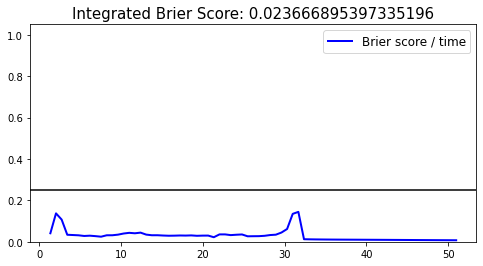

0.9167076818233446


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:300: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [ ]:
from matplotlib import pyplot as plt
%pylab inline

pi, mu, std, survival_predictions, mlt = dws.prdict_survival(X_valid)
pi, mu, std, survival_predictions, mlt = pi.cpu(), mu.cpu(), std.cpu(), survival_predictions.cpu(), mlt.cpu().data.numpy()
survival_predictions = np.squeeze(survival_predictions.data.numpy())

brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train.astype(float), X_valid.values, T_valid, E_valid.astype(float), survival_predictions.T, plot=True)
figure.show()
c_index = dws.c_index(mlt, T_valid, E_valid)
print(c_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:284: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:285: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



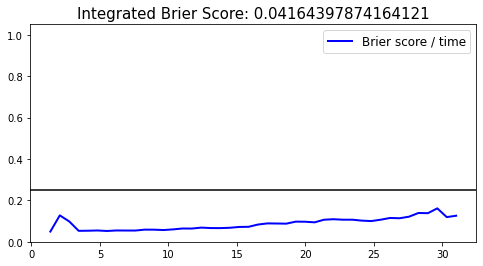

0.9102309727309728


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:300: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [ ]:
pi, mu, std, survival_predictions, mlt = dws.prdict_survival(X_test)
pi, mu, std, survival_predictions, mlt = pi.cpu(), mu.cpu(), std.cpu(), survival_predictions.cpu(), mlt.cpu().data.numpy()
survival_predictions = np.squeeze(survival_predictions.data.numpy())

brier_res, ibs, figure = dws.b_index(X_train.values, T_train, E_train.astype(float), X_test.values, T_test, E_test.astype(float), survival_predictions.T, plot=True)
figure.show()
#mlt = torch.sum(pi[:,[1]] * torch.exp(mu[:,[1]] + torch.pow(std[:,[1]], 2)/2), 1).data.numpy() #LOGNORMAL
c_index = dws.c_index(mlt, T_test, E_test)
print(c_index)

In [ ]:
mlt[E_test==1].shape

(71,)

In [ ]:
non_censored_diagn(data_test, E_test, T_test, mlt, 3).show()

In [35]:
idx = data_test.loc[(data_test[event_column]==1) & (data_test[time_column]>=4) & (data_test[time_column]<=7)].index.values
plot_surv(idx, T_test, mlt, survival_predictions, dws.times, 0.01).show()

In [ ]:
imp = dws.feature_importance(10, X_test, T_test, E_test, batch_size=None)
fig = go.Figure()
for i in range(X_test.shape[1]):
    fig.add_trace(go.Box(x=imp['importances'][:, i], name=X_test.columns[i]))
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig.write_html("/content/drive/My Drive/Colab Notebooks/survival analysis/phoenix_employee_attrition/phoenix_data/feat_imp.html")

In [ ]:
surv = pd.DataFrame(survival_predictions)
times = pd.DataFrame(dws.times, columns=['Times'])
res = pd.concat((times, surv), 1)
data_test.to_csv('/content/drive/My Drive/Colab Notebooks/survival analysis/phoenix_employee_attrition/phoenix_data/test_data.csv', index=False)
res.to_csv('/content/drive/My Drive/Colab Notebooks/survival analysis/phoenix_employee_attrition/phoenix_data/surve_curve.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



In [ ]:
pi

tensor([[0.0222, 0.9778],
        [0.0166, 0.9834],
        [0.0194, 0.9806],
        [0.0169, 0.9831],
        [0.0202, 0.9798],
        [0.0176, 0.9824],
        [0.0231, 0.9769],
        [0.0198, 0.9802],
        [0.0213, 0.9787],
        [0.0265, 0.9735],
        [0.0282, 0.9718],
        [0.0195, 0.9805],
        [0.0147, 0.9853],
        [0.0209, 0.9791],
        [0.0171, 0.9829],
        [0.0291, 0.9709],
        [0.0198, 0.9802],
        [0.0244, 0.9756],
        [0.0268, 0.9732],
        [0.0211, 0.9789],
        [0.0191, 0.9809],
        [0.0251, 0.9749],
        [0.0209, 0.9791],
        [0.0230, 0.9770],
        [0.0230, 0.9770],
        [0.0216, 0.9784],
        [0.0156, 0.9844],
        [0.0240, 0.9760],
        [0.0204, 0.9796],
        [0.0208, 0.9792],
        [0.0225, 0.9775],
        [0.0194, 0.9806],
        [0.0205, 0.9795],
        [0.0222, 0.9778],
        [0.0238, 0.9762],
        [0.0205, 0.9795],
        [0.0190, 0.9810],
        [0.0201, 0.9799],
        [0.0

In [ ]:
mu

tensor([[ 3.8614,  0.9315,  3.2493],
        [ 1.3498, -1.0948,  2.3471],
        [ 0.3427, -0.0226,  1.5585],
        ...,
        [ 0.8125, -2.1283,  1.4230],
        [ 1.2591,  0.3586,  2.1618],
        [ 2.6449,  0.5053,  2.6158]], grad_fn=<ToCopyBackward0>)

In [ ]:
std

tensor([[14.8227,  1.0203],
        [14.4973,  0.6888],
        [14.6349,  0.7743],
        [14.4719,  0.8102],
        [14.7497,  0.9212],
        [14.6165,  0.8155],
        [14.8684,  1.1968],
        [14.8096,  0.9206],
        [14.5840,  0.8469],
        [14.6584,  0.8935],
        [14.9137,  1.1965],
        [14.7564,  1.0018],
        [14.6818,  0.7946],
        [14.7262,  0.9270],
        [14.6526,  0.7617],
        [14.7650,  1.1986],
        [14.5175,  0.8333],
        [14.6628,  0.9095],
        [14.7494,  1.1173],
        [14.7694,  1.0507],
        [14.5623,  0.9444],
        [14.8795,  1.0121],
        [14.4896,  0.6833],
        [14.6849,  0.9337],
        [14.6404,  1.0554],
        [14.8584,  1.1834],
        [14.7299,  0.8454],
        [14.6551,  0.9074],
        [14.4811,  0.7782],
        [14.7983,  0.9777],
        [14.8057,  1.0590],
        [14.6413,  0.8496],
        [14.8289,  0.9783],
        [14.8443,  0.9030],
        [14.7555,  1.0000],
        [14.7538,  0

In [ ]:
import tensorflow_probability as tfp
import torch
import torch.nn as nn
import numpy as np

In [ ]:
tfp.distributions.InverseGaussian(torch.from_numpy(np.asarray([4,5])), torch.from_numpy(np.asarray([4,5])))

TypeError: ignored